## Mod 6 Lecture 4 Data Challenge:  Simple Linear Regression

### Purpose

**Purpose**: Run a simple linear regression (SLR) on the NYC Yellow Taxi Dec 2023 excerpt to explain how a single input (X) relates to Tip % (Y). Practice picking a sensible X, fitting the line, and interpreting β₁, p‑value, and 95% confidence interval—plus basic assumption checks.

### Data
We are looking at ONE month's worth of data (December 2023 to be exact).  Remember the data dictionary is found [HERE](https://data.cityofnewyork.us/Transportation/2023-Yellow-Taxi-Trip-Data/4b4i-vvec/about_data)

### Instructor Guidance (10 Minutes)

#### Goals

- Pick an X with a plausible relationship to Tip % that is available at trip time.

- Communicate β₁ with units, p-vale, and a 95% CI.

#### Special considerations

- `Tip %` is `tip_amount / fare_amount`. Choosing `fare_amount` as X can create a built‑in relationship because it’s in the definition of Y (mathematical coupling). Encourage alternative X’s like `trip_distance`, `pickup_hour (as numeric)`, or `passenger_count`.

- Linearity check: Is the relationship roughly straight‑line? If X is discrete (e.g., passenger_count), SLR still works but discuss meaning.

- Intercept meaning: If X=0 is unrealistic (0 miles), say the intercept is just a mathematical anchor.

- Outliers: Large distances/fares can dominate. Consider trimming extremes thoughtfully or explaining how you would handle outliers.  

#### Critical thinking prompts as you work through the challenge (be prepared to answer at the end):

- Which input would you use to make a decision before the ride starts? Why?

- If β₁ is tiny but the p‑value is very small, is that useful for the business?

- If residuals (can only get residuals after fitting the model) "fan out" as X grows, what story might that tell about tipping behavior?

- Would your conclusion change if you looked at daytime vs. late night rides separately?

### Student Tasks (35 minutes)

Step 0 — Load Packages and Data, Fix Data Types, Create Tip % Column 

**Hint**:  You did this in the Code-Along, refer back to the notebook to help you!

In [22]:
# import packages
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

In [13]:
# Read in data and look at it!

df = pd.read_csv("/Users/kabbo/Downloads/2023_Yellow_Taxi_Trip_Data_20251015.csv", low_memory=False)
display(df.head())
display(df.info())
display(df.describe())

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,12/01/2023 04:11:39 PM,12/01/2023 04:19:13 PM,2.0,0.69,1.0,N,141,140,1,7.9,2.5,0.5,3,0.0,1.0,17.4,2.5,0.0
1,1,12/01/2023 04:11:39 PM,12/01/2023 04:20:41 PM,3.0,1.1,1.0,N,236,263,2,10,5.0,0.5,0,0.0,1.0,16.5,2.5,0.0
2,2,12/01/2023 04:11:39 PM,12/01/2023 04:20:38 PM,1.0,1.57,1.0,N,48,239,4,-10.7,-2.5,-0.5,0,0.0,-1.0,-17.2,-2.5,0.0
3,2,12/01/2023 04:11:39 PM,12/01/2023 04:20:38 PM,1.0,1.57,1.0,N,48,239,4,10.7,2.5,0.5,0,0.0,1.0,17.2,2.5,0.0
4,1,12/01/2023 04:11:39 PM,12/01/2023 04:34:39 PM,2.0,3,1.0,N,164,211,1,21.9,5.0,0.5,3,0.0,1.0,31.4,2.5,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3310907 entries, 0 to 3310906
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          object 
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           int64  
 10  fare_amount            object 
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             object 
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           object 
 17  congestion_surcharge   float64
 18  airport_fee            float64
dtypes: float64(8), int64(4), object(7)
memory usage: 479.9+ MB


None

,VendorID,passenger_count,RatecodeID,PULocationID,DOLocationID,payment_type,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,airport_fee
count,3.310907e+06,3.133527e+06,3.133527e+06,3.310907e+06,3.310907e+06,3.310907e+06,3.310907e+06,3.310907e+06,3.310907e+06,3.310907e+06,3.133527e+06,3.133527e+06
mean,1.750368e+00,1.409560e+00,1.784972e+00,1.650685e+02,1.639182e+02,1.168633e+00,1.485240e+00,4.828656e-01,5.734011e-01,9.758456e-01,2.270032e+00,1.367974e-01
std,4.356449e-01,9.117169e-01,8.283274e+00,6.428330e+01,6.968454e+01,5.959677e-01,1.814139e+00,1.206643e-01,2.228458e+00,2.170912e-01,8.078364e-01,4.796868e-01
min,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-3.917000e+01,-5.000000e-01,-7.000000e+01,-1.000000e+00,-2.500000e+00,-1.750000e+00
25%,1.000000e+00,1.000000e+00,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,1.000000e+00,2.500000e+00,0.000000e+00
50%,2.000000e+00,1.000000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.000000e+00,5.000000e-01,0.000000e+00,1.000000e+00,2.500000e+00,0.000000e+00
75%,2.000000e+00,2.000000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,2.500000e+00,5.000000e-01,0.000000e+00,1.000000e+00,2.500000e+00,0.000000e+00
max,6.000000e+00,9.000000e+00,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,5.168000e+01,4.217000e+01,1.613800e+02,1.000000e+00,2.500000e+00,1.750000e+00


In [14]:
# Coerce fare, tip, distance to numeric safely
num_cols = ['fare_amount', 'tip_amount', 'trip_distance']
for c in num_cols:
    df[c] = pd.to_numeric(
        df[c].astype(str).str.strip().str.replace(r'[^0-9.+\-eE]', '', regex=True),
        errors="coerce"
)

Step 1 — Choose Your X (be sure to chose an X variable that would be available at trip time (not after the trip takes place))

Add a 2–3 sentence rationale in Markdown: Why could X relate to `tip_pct`? Why is it available **when the decision is made** (meaning driver has the information before the actual drive takes place)?

In [15]:
# Clean data some and add a new column called 'tip_pct' as the target 
df = df[(df['fare_amount'] > 0) & (df['tip_amount'] >= 0) & (df['trip_distance'] > 0) ]
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=num_cols)
df['tip_pct'] = (df['tip_amount'] / df['trip_distance']).clip(0,1)

trip_distance is a plausible predictor for Tip % because it is safe to assume that tipping behavior may change with trip length. Initally, I wanted to use payment_type but it does not meet the criteria of "driver has the info before the actual drive takes place" as the driver does not know if they will get paid in cash, card or something else. The assumption here is that passengers might tip a lower percentage on very long, expensive airport rides compared to short, cross-town trips. This variable is available "at trip time" because the passenger must tell the driver their destination (like DOLocationID) before the trip can begin.

Step 2 — Quick Visual Check (Linearity & Outliers)

Add a 2-3 sentence rationale on how you would handle outliers or how you did handle outliers (if you handled them for this challenge).  Is the linear relationship there between your X and Y?  Is it a strong relationship?  What is the benefits of a strong relationship between X and Y?

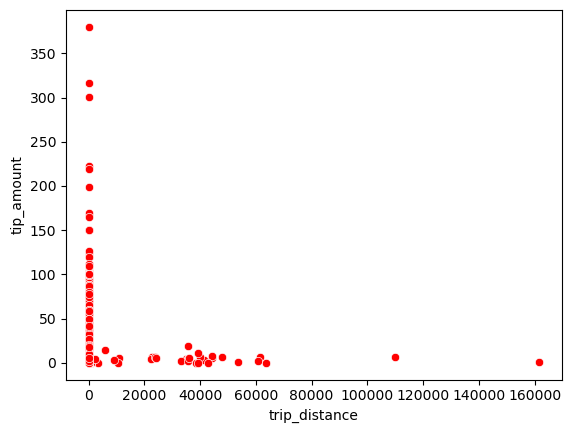

In [16]:
import matplotlib.pyplot as plt 
import seaborn as sns   
fig = plt.figure()
sns.scatterplot(data=df, x='trip_distance', y='tip_amount', color='red')
plt.show()

In order to handle outliers, I would only focus on the quantiles in the viz that has most of the data points clumped together. Depending on the business case, I would drop or ignore the outliers.

In [17]:
Q1 = df['trip_distance'].quantile(0.25)
Q3 = df['trip_distance'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['trip_distance'] >= Q1 - 1.5*IQR) & (df['trip_distance'] <= Q3 + 1.5*IQR)]

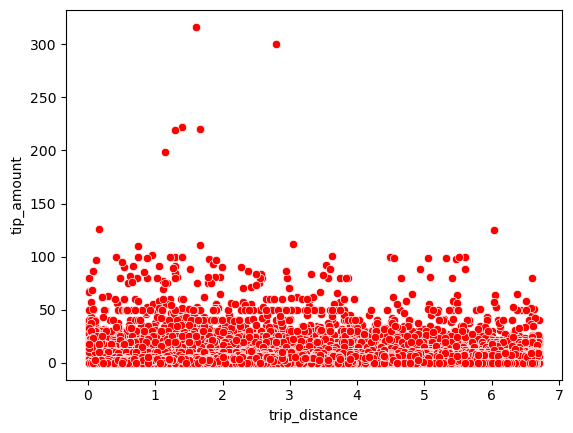

In [18]:
import matplotlib.pyplot as plt 
import seaborn as sns   
fig = plt.figure()
sns.scatterplot(data=df, x='trip_distance', y='tip_amount', color='red')
plt.show()

Step 3 — Fit SLR Model to Data

In [19]:
import statsmodels.api as sm

x = sm.add_constant(df[['trip_distance']])  # independent variable(s)
y = df['tip_pct']  # dependent variable

model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                tip_pct   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     7498.
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        11:53:06   Log-Likelihood:            -1.5460e+06
No. Observations:             2788377   AIC:                         3.092e+06
Df Residuals:                 2788375   BIC:                         3.092e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.7761      0.000   1751.448

In [23]:
tips_vs_distance_count = ols('tip_pct ~ trip_distance', data=df).fit()
print(tips_vs_distance_count.params)

Intercept        0.776149
trip_distance   -0.016505
dtype: float64


Step 4 — Interpret the model's coefficients, p-values, and CI 

The model predicts that :
- When there is no distance travelled, the expected tip percentage would be about 77.6%
- For every additional unit of distance travelled. the tip percentage decreases by ~1.7%
- It seems that there is a negative relationshop between trip distance and tip percentage.
- As the trip distance increases, the tip percentage tends to go downwards.
- The p-value for trip_distance is 0.000 so this means the relationship is statistically significant, in other words, it's very unlinkely to be due to random chance.



Step 5 — Post‑Fit Assumption Glance 

Add 2-3 sentences about the residuals any curve? funnel shape? obvious outliers?  How would you go about checking if residuals were normally distributed?  

In [25]:
tips_vs_distance_count.fittedvalues

0          0.764760
1          0.757993
3          0.750236
4          0.726633
6          0.755683
             ...   
3310899    0.731585
3310900    0.752051
3310901    0.764430
3310902    0.748090
3310905    0.775984
Length: 2788377, dtype: float64

In [26]:
tips_vs_distance_count.resid

0          0.235240
1         -0.757993
3         -0.750236
4          0.273367
6         -0.755683
             ...   
3310899    0.268415
3310900   -0.752051
3310901   -0.764430
3310902    0.251910
3310905    0.224016
Length: 2788377, dtype: float64

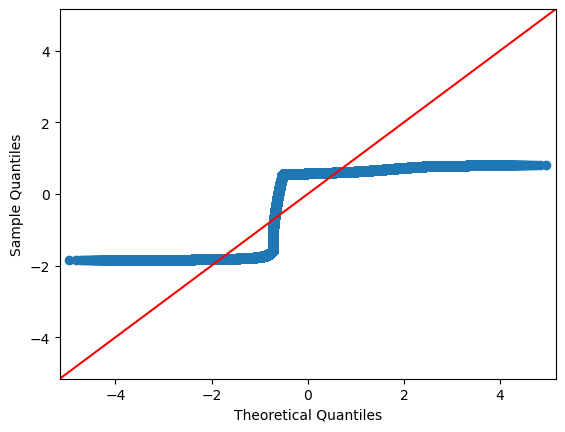

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

residuals = model.resid
sm.qqplot(residuals, line='45', fit=True)  # Q–Q plot
plt.show()

It seems my model did not work. 

For a normal distribution, the blue dots (my data) should fall closely along the red 45-degree line. My data forms a distinct **"S" or step-like shape**.

The long, flat, horizontal segments tell us that the data is **discrete or quantized**, not continuous.

This shape means that large portions of my data is "clumped" together at a few specific values.

This is almost certainly happening because people don't tip on a continuous scale. They tip common, discrete amounts example: $5, $10 or $20. The plot is picking up on these massive "clumps" of data at those common tip percentages, which causes the residuals to clump up as well.

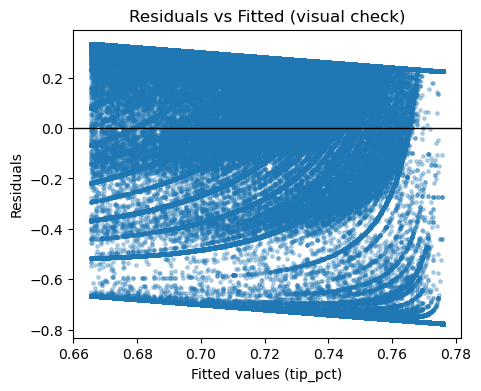

In [28]:
#RUN THIS CELL WITHOUT CHANGES
resid = model.resid
fitted = model.fittedvalues
plt.figure(figsize=(5,4))
plt.scatter(fitted, resid, s=6, alpha=0.3)
plt.axhline(0, color='k', lw=1)
plt.xlabel('Fitted values (tip_pct)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted (visual check)')
plt.show()

### Reflection (10-15 mins)

**In addition to the critical thinking questions at the top** of the notebook be prepared to discuss: 

- If you had to make a decision tomorrow, would this simple model be enough? Why/why not?
This model would most definitely not be enough. As we can see from the residuals graph, we did not.

        For a normal distribution, the blue dots (my data) should fall closely along the red 45-degree line. My data forms a distinct **"S" or step-like shape**. 

- What’s one different X you’d try next and why?
        
        Even though it did not meet the requirements, I would be interested to see what the data looks like if I chose payment_type as my X.
